In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.metrics import (f1_score, balanced_accuracy_score, 
    classification_report, confusion_matrix, roc_curve, auc)
import torch
import torchvision
from torchvision import transforms, datasets
import tqdm

In [2]:
# !python eval.py --model=DeepDerm --data_dir=DDI --eval_dir=DDI-results 

In [3]:


# Examples:

# (1) w/command line interface
# # evaluate DeepDerm on DDI and store results in `DDI-results`
# >>>python3 eval.py --model=DeepDerm --data_dir=DDI --eval_dir=DDI-results 

# (2) w/python functions
# >>>import eval
# >>>model = eval.load_model("DeepDerm") # load DeepDerm model
# >>>eval_results = eval.eval_model(model, "DDI") # evaluate images in DDI folder


# google drive paths to models
MODEL_WEB_PATHS = {
'HAM10000':'https://drive.google.com/uc?id=1ToT8ifJ5lcWh8Ix19ifWlMcMz9UZXcmo',
'DeepDerm':'https://drive.google.com/uc?id=1OLt11htu9bMPgsE33vZuDiU5Xe4UqKVJ',
# robust training algorithms
'GroupDRO':'https://drive.google.com/uc?id=193ippDUYpMaOaEyLjd1DNsOiW0aRXL75',
'CORAL':   'https://drive.google.com/uc?id=18rMU0nRd4LiHN9WkXoDROJ2o2sG1_GD8',
'CDANN':   'https://drive.google.com/uc?id=1PvvgQVqcrth840bFZ3ddLdVSL7NkxiRK',
}

# thresholds determined by maximizing F1-score on the test split of the train 
#   dataset for the given algorithm
MODEL_THRESHOLDS = {
    'HAM10000':0.733,
    'DeepDerm':0.687,
    # robust training algorithms
    'GroupDRO':0.980,
    'CORAL':0.990,
    'CDANN':0.980,
}

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_dir', type=str, default="DDI-models", 
        help="File path for where to save models.")
    parser.add_argument('--model', type=str, default="DeepDerm", 
        help="Name of the model to load (HAM10000, DeepDerm, GroupDRO, CORAL,"\
             " or CDANN).")
    parser.add_argument('--no_download', action='store_true', default=False,
        help="Set to disable downloading models.")
    parser.add_argument('--data_dir', type=str, default="DDI", 
        help="Folder containing dataset to load. Structure should match the"\
             " root directory in torchvision.datasets.ImageFolder with 2"\
             " classes: benign (class 0) and malignant (class 1).")
    parser.add_argument('--eval_dir', type=str, default="DDI-results", 
        help="Folder to store evaluation results.")
    parser.add_argument('--use_gpu', action='store_true', default=False,
        help="Set to use GPU for evaluation.")
    parser.add_argument('--plot', action='store_true', default=False,
        help="Set to show ROC plot.")
    args = parser.parse_args()
    return args


def load_model(model_name, save_dir="DDI-models", download=True):
    """Load the model and download if necessary. Saves model to provided save 
    directory."""

    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name.lower()}.pth")
    if not os.path.exists(model_path):
        if not download:
            raise Exception("Model not downloaded and download option not"\
                            " enabled.")
        else:
            # Requires installation of gdown (pip install gdown)
            import gdown
            gdown.download(MODEL_WEB_PATHS[model_name], model_path)
    model = torchvision.models.inception_v3(init_weights=False, pretrained=False, transform_input=True)
    model.fc = torch.nn.Linear(2048, 2)
    model.AuxLogits.fc = torch.nn.Linear(768, 2)
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model._ddi_name = model_name
    model._ddi_threshold = MODEL_THRESHOLDS[model_name]
    model._ddi_web_path = MODEL_WEB_PATHS[model_name]
    return model

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = os.path.abspath(self.imgs[index][0])
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



In [3]:
# google drive paths to models
MODEL_WEB_PATHS = {
'HAM10000':'https://drive.google.com/uc?id=1ToT8ifJ5lcWh8Ix19ifWlMcMz9UZXcmo',
'DeepDerm':'https://drive.google.com/uc?id=1OLt11htu9bMPgsE33vZuDiU5Xe4UqKVJ',
# robust training algorithms
'GroupDRO':'https://drive.google.com/uc?id=193ippDUYpMaOaEyLjd1DNsOiW0aRXL75',
'CORAL':   'https://drive.google.com/uc?id=18rMU0nRd4LiHN9WkXoDROJ2o2sG1_GD8',
'CDANN':   'https://drive.google.com/uc?id=1PvvgQVqcrth840bFZ3ddLdVSL7NkxiRK',
}

# thresholds determined by maximizing F1-score on the test split of the train 
#   dataset for the given algorithm
MODEL_THRESHOLDS = {
    'HAM10000':0.733,
    'DeepDerm':0.687,
    # robust training algorithms
    'GroupDRO':0.980,
    'CORAL':0.990,
    'CDANN':0.980,
}


def load_model(model_name, save_dir="DDI-models", download=True):
    """Load the model and download if necessary. Saves model to provided save 
    directory."""

    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name.lower()}.pth")
    if not os.path.exists(model_path):
        if not download:
            raise Exception("Model not downloaded and download option not"\
                            " enabled.")
        else:
            # Requires installation of gdown (pip install gdown)
            import gdown
            gdown.download(MODEL_WEB_PATHS[model_name], model_path)
    model = torchvision.models.inception_v3(init_weights=False, pretrained=False, transform_input=True)
    model.fc = torch.nn.Linear(2048, 2)
    model.AuxLogits.fc = torch.nn.Linear(768, 2)
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model._ddi_name = model_name
    model._ddi_threshold = MODEL_THRESHOLDS[model_name]
    model._ddi_web_path = MODEL_WEB_PATHS[model_name]
    return model

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = os.path.abspath(self.imgs[index][0])
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm


In [ ]:
eval_dir = "finetune_other_models"
model_name = "DeepDerm" #"HAM10000"
save_dir="finetune_other_models"

model = load_model(model_name, 
    save_dir=save_dir, download=True)

from torchsummary import summary

summary(model, input_size=(3, 224, 224))

In [17]:
from torchsummary import summary

def train_model(model, train_dir, val_dir, epochs=100, batch_size=16, use_gpu=False, learning_rate=0.0005, show_plot=False):
    """Train a model on the specified dataset.

    Args:
        model: The neural network model to train.
        train_dir: Directory containing the training data.
        val_dir: Directory containing the validation data.
        epochs: Number of epochs to train for.
        batch_size: Batch size for training.
        use_gpu: Boolean to use GPU if available.
        learning_rate: Learning rate for the optimizer.
        show_plot: Plot training and validation loss after training.
    """

    # Check for GPU availability
    use_gpu = use_gpu and torch.cuda.is_available()
    device = torch.device("cuda" if use_gpu else "cpu")
    model.to(device)
    
    train_transforms = transforms.Compose([
        transforms.Resize(256),             # Resize images to 256x256
        transforms.CenterCrop(224),         # Crop a 224x224 patch from the center
        transforms.ToTensor(),              # Convert images to Tensor
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize for pre-trained models
        #                     std=[0.229, 0.224, 0.225])
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same normalization for consistency
        #                     std=[0.229, 0.224, 0.225])
    ])


    # Setup data loaders
    train_loader = DataLoader(
        datasets.ImageFolder(train_dir, transform=train_transforms),
        batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(
        datasets.ImageFolder(val_dir, transform=val_transforms),
        batch_size=batch_size, shuffle=False)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training and validation loop
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        for images, labels in tqdm.tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            print(images.shape)
            print(summary(model, input_size=(batch_size, images.shape[0], images.shape[1], images.shape[2])))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Optionally plot the training and validation losses
    if show_plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    return model


In [ ]:
# # Example model definition (e.g., a simple CNN or a preloaded model)
# # model = torchvision.models.resnet18(pretrained=True)  # Just as an example

# # Paths to your training and validation data
# train_dir = 'RETFound_MAE/DDI_data/train'
# val_dir = 'RETFound_MAE/DDI_data/val'

# # Train the model
# trained_model = train_model(model, train_dir, val_dir, epochs=100, use_gpu=True, show_plot=True)

In [32]:
def eval_model(model, image_dir, use_gpu=False, show_plot=False):
    """Evaluate loaded model on provided image dataset. Assumes supplied image 
    directory corresponds to `root` input for torchvision.datasets.ImageFolder
    class. Assumes the data is split into binary/malignant labels, as this is 
    what our models are trained+evaluated on."""

    use_gpu = (use_gpu and torch.cuda.is_available())
    device = torch.device("cuda") if use_gpu else torch.device("cpu")
    dataset = ImageFolderWithPaths(
                    image_dir,
                    transforms.Compose([
                        transforms.Resize(299),
                        transforms.CenterCrop(224),
                        transforms.ToTensor()
                        ]))
    print(dataset)        
    dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=32, shuffle=False,
                    num_workers=0, pin_memory=use_gpu)

    # prepare model for evaluation
    model.to(device).eval()

    # log output for all images in dataset
    hat, star, all_paths = [], [], []
    for batch in tqdm.tqdm(enumerate(dataloader)):
        # print("batch:", batch)
        i, (images, target, paths) = batch
        images = images.to(device)
        target = target.to(device)

        with torch.no_grad():
            output = model(images)

        hat.append(output[:,1].detach().cpu().numpy())
        star.append(target.cpu().numpy())
        all_paths.append(paths)

    hat = np.concatenate(hat)
    star = np.concatenate(star)
    all_paths = np.concatenate(all_paths)
    threshold = model._ddi_threshold
    m_name = model._ddi_name
    m_web_path = model._ddi_web_path

    report = classification_report(star, (hat>threshold).astype(int), 
        target_names=["benign","malignant"])
    fpr, tpr, _ = roc_curve(star, hat, pos_label=1,
                                sample_weight=None,
                                drop_intermediate=True)
    auc_est = auc(fpr, tpr)

    if show_plot:
        _=plt.plot(fpr, tpr, 
            color="blue", linestyle="-", linewidth=2, 
            marker="o", markersize=2, 
            label=f"AUC={auc_est:.3f}")[0]
        plt.show()
        plt.close()

    eval_results = {'predicted_labels':hat, # predicted labels by model
                    'true_labels':star,     # true labels
                    'images':all_paths,     # image paths
                    'report':report,        # sklearn classification report
                    'ROC_AUC':auc_est,      # ROC-AUC
                    'threshold':threshold,  # >= threshold ==> malignant
                    'model':m_name,         # model name
                    'web_path':m_web_path,  # web link to download model
                    }

    return eval_results

Dataset ImageFolderWithPaths
    Number of datapoints: 132
    Root location: DDI_data/test
    StandardTransform
Transform: Compose(
               Resize(size=299, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
           )


0it [00:00, ?it/s]

5it [00:03,  1.34it/s]


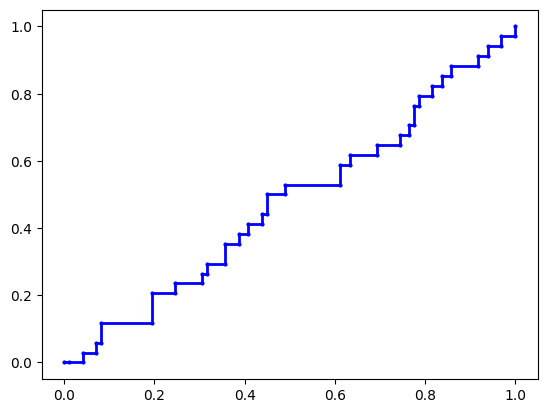

In [39]:

# evaluate results on data
eval_results = eval_model(model, "DDI_data/test", use_gpu=True, 
            show_plot=True)

# save evaluation results in a .pkl file 
if eval_dir:
    os.makedirs(eval_dir, exist_ok=True)
    eval_save_path = os.path.join(eval_dir, 
                                    f"{model_name}-evaluation.pkl")
    with open(eval_save_path, 'wb') as f:
        pickle.dump(eval_results, f)

# print(eval_results)
    # load results with:
    #with open(eval_save_path, 'rb') as f:
    #    results = pickle.load(f)


In [41]:
eval_results['ROC_AUC']

0.4765906362545018

In [40]:
eval_results['report']

'              precision    recall  f1-score   support\n\n      benign       0.73      0.71      0.72        98\n   malignant       0.22      0.24      0.23        34\n\n    accuracy                           0.59       132\n   macro avg       0.48      0.47      0.48       132\nweighted avg       0.60      0.59      0.59       132\n'